In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from utils_2 import fashion_mnist, plot_graphs, fashion_mnist_transform, plot_mnist

In [67]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)
#data = datasets.FashionMNIST('./FashionMNIST_data', train=True, download=True, transform=None)
#img, cls = data.__getitem__(0)
#img

# pltsize=1
# plt.figure(figsize=(10*pltsize, pltsize))

# for i in range(10):
#     plt.subplot(1,10,i+1)
#     plt.axis('off')
#     plt.imshow(data[i].numpy().reshape(28,28), cmap="gray")
#     #plt.title('Class: '+str(y_train[i].item()))

In [68]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss
    

In [69]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)            

In [70]:
def test(models, loader, log=None, train_set=False):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    if train_set:
        report = 'Train set:\n' + lines
    else:
        report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [71]:
models = {'default': Net(False, False), 'bn': Net(True, False)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [72]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
                   
    for model in models.values():
        model.eval()
    test(models, train_loader, train_log, True)
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.321532 bn: 2.305154
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.899295 bn: 0.913057
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.558034 bn: 0.537512
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.608739 bn: 0.613517
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.441325 bn: 0.388614
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.460096 bn: 0.475215
Train set:
default: Loss: 0.4793	Accuracy: 41705.0/50000 (83%)
bn: Loss: 0.4533	Accuracy: 42132.0/50000 (84%)

Test set:
default: Loss: 0.4738	Accuracy: 8358.0/10000 (84%)
bn: Loss: 0.4499	Accuracy: 8451.0/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.520200 bn: 0.539464
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.481419 bn: 0.450375
Train Epoch: 2 [20000/50000 (40%)]	Losses default: 0.357308 bn: 0.393528
Train Epoch: 2 [30000/50000 (60%)]	Losses default: 0.254235 bn: 0.260608
Train Epoch: 2 [40000/50000 (80%)]	Losses default: 0.260825 

Train Epoch: 13 [50000/50000 (100%)]	Losses default: 0.168053 bn: 0.214116
Train set:
default: Loss: 0.2644	Accuracy: 45161.0/50000 (90%)
bn: Loss: 0.2246	Accuracy: 45852.0/50000 (92%)

Test set:
default: Loss: 0.3114	Accuracy: 8846.0/10000 (88%)
bn: Loss: 0.2943	Accuracy: 8940.0/10000 (89%)

Train Epoch: 14 [0/50000 (0%)]	Losses default: 0.378428 bn: 0.347125
Train Epoch: 14 [10000/50000 (20%)]	Losses default: 0.142670 bn: 0.183524
Train Epoch: 14 [20000/50000 (40%)]	Losses default: 0.223671 bn: 0.218761
Train Epoch: 14 [30000/50000 (60%)]	Losses default: 0.257582 bn: 0.209956
Train Epoch: 14 [40000/50000 (80%)]	Losses default: 0.258067 bn: 0.255897
Train Epoch: 14 [50000/50000 (100%)]	Losses default: 0.191844 bn: 0.200934
Train set:
default: Loss: 0.2471	Accuracy: 45548.0/50000 (91%)
bn: Loss: 0.2125	Accuracy: 46070.0/50000 (92%)

Test set:
default: Loss: 0.2989	Accuracy: 8924.0/10000 (89%)
bn: Loss: 0.2891	Accuracy: 8938.0/10000 (89%)

Train Epoch: 15 [0/50000 (0%)]	Losses default: 

Train Epoch: 26 [10000/50000 (20%)]	Losses default: 0.309247 bn: 0.276015
Train Epoch: 26 [20000/50000 (40%)]	Losses default: 0.091153 bn: 0.050711
Train Epoch: 26 [30000/50000 (60%)]	Losses default: 0.057929 bn: 0.072445
Train Epoch: 26 [40000/50000 (80%)]	Losses default: 0.142881 bn: 0.118227
Train Epoch: 26 [50000/50000 (100%)]	Losses default: 0.171775 bn: 0.126411
Train set:
default: Loss: 0.1857	Accuracy: 46637.0/50000 (93%)
bn: Loss: 0.1534	Accuracy: 47249.0/50000 (94%)

Test set:
default: Loss: 0.3005	Accuracy: 8927.0/10000 (89%)
bn: Loss: 0.2956	Accuracy: 8939.0/10000 (89%)

Train Epoch: 27 [0/50000 (0%)]	Losses default: 0.069917 bn: 0.087888
Train Epoch: 27 [10000/50000 (20%)]	Losses default: 0.157746 bn: 0.141748
Train Epoch: 27 [20000/50000 (40%)]	Losses default: 0.163924 bn: 0.201506
Train Epoch: 27 [30000/50000 (60%)]	Losses default: 0.236340 bn: 0.193163
Train Epoch: 27 [40000/50000 (80%)]	Losses default: 0.176427 bn: 0.168089
Train Epoch: 27 [50000/50000 (100%)]	Losses d

Train Epoch: 38 [50000/50000 (100%)]	Losses default: 0.192493 bn: 0.284779
Train set:
default: Loss: 0.1252	Accuracy: 47843.0/50000 (96%)
bn: Loss: 0.1063	Accuracy: 48176.0/50000 (96%)

Test set:
default: Loss: 0.3120	Accuracy: 8955.0/10000 (90%)
bn: Loss: 0.3085	Accuracy: 9014.0/10000 (90%)

Train Epoch: 39 [0/50000 (0%)]	Losses default: 0.127672 bn: 0.210973
Train Epoch: 39 [10000/50000 (20%)]	Losses default: 0.103928 bn: 0.059527
Train Epoch: 39 [20000/50000 (40%)]	Losses default: 0.080301 bn: 0.108243
Train Epoch: 39 [30000/50000 (60%)]	Losses default: 0.181433 bn: 0.167367
Train Epoch: 39 [40000/50000 (80%)]	Losses default: 0.139696 bn: 0.263668
Train Epoch: 39 [50000/50000 (100%)]	Losses default: 0.151240 bn: 0.156517
Train set:
default: Loss: 0.1238	Accuracy: 47875.0/50000 (96%)
bn: Loss: 0.1063	Accuracy: 48237.0/50000 (96%)

Test set:
default: Loss: 0.3138	Accuracy: 8912.0/10000 (89%)
bn: Loss: 0.3191	Accuracy: 8959.0/10000 (90%)

Train Epoch: 40 [0/50000 (0%)]	Losses default: 

Train Epoch: 51 [10000/50000 (20%)]	Losses default: 0.033593 bn: 0.070321
Train Epoch: 51 [20000/50000 (40%)]	Losses default: 0.071531 bn: 0.120404
Train Epoch: 51 [30000/50000 (60%)]	Losses default: 0.094630 bn: 0.156892
Train Epoch: 51 [40000/50000 (80%)]	Losses default: 0.140209 bn: 0.099838
Train Epoch: 51 [50000/50000 (100%)]	Losses default: 0.044555 bn: 0.061103
Train set:
default: Loss: 0.0906	Accuracy: 48463.0/50000 (97%)
bn: Loss: 0.0756	Accuracy: 48797.0/50000 (98%)

Test set:
default: Loss: 0.3615	Accuracy: 8910.0/10000 (89%)
bn: Loss: 0.3447	Accuracy: 8992.0/10000 (90%)

Train Epoch: 52 [0/50000 (0%)]	Losses default: 0.037738 bn: 0.063486
Train Epoch: 52 [10000/50000 (20%)]	Losses default: 0.137916 bn: 0.161367
Train Epoch: 52 [20000/50000 (40%)]	Losses default: 0.086130 bn: 0.176584
Train Epoch: 52 [30000/50000 (60%)]	Losses default: 0.017942 bn: 0.057954
Train Epoch: 52 [40000/50000 (80%)]	Losses default: 0.092932 bn: 0.140086
Train Epoch: 52 [50000/50000 (100%)]	Losses d

Train Epoch: 63 [50000/50000 (100%)]	Losses default: 0.059481 bn: 0.062444
Train set:
default: Loss: 0.0576	Accuracy: 49123.0/50000 (98%)
bn: Loss: 0.0542	Accuracy: 49179.0/50000 (98%)

Test set:
default: Loss: 0.3979	Accuracy: 8882.0/10000 (89%)
bn: Loss: 0.3757	Accuracy: 8993.0/10000 (90%)

Train Epoch: 64 [0/50000 (0%)]	Losses default: 0.057941 bn: 0.051796
Train Epoch: 64 [10000/50000 (20%)]	Losses default: 0.077618 bn: 0.114126
Train Epoch: 64 [20000/50000 (40%)]	Losses default: 0.143038 bn: 0.041662
Train Epoch: 64 [30000/50000 (60%)]	Losses default: 0.094308 bn: 0.119454
Train Epoch: 64 [40000/50000 (80%)]	Losses default: 0.038467 bn: 0.085532
Train Epoch: 64 [50000/50000 (100%)]	Losses default: 0.022143 bn: 0.037660
Train set:
default: Loss: 0.0624	Accuracy: 48953.0/50000 (98%)
bn: Loss: 0.0560	Accuracy: 49136.0/50000 (98%)

Test set:
default: Loss: 0.4165	Accuracy: 8922.0/10000 (89%)
bn: Loss: 0.3780	Accuracy: 8985.0/10000 (90%)

Train Epoch: 65 [0/50000 (0%)]	Losses default: 

Train Epoch: 76 [10000/50000 (20%)]	Losses default: 0.029046 bn: 0.024903
Train Epoch: 76 [20000/50000 (40%)]	Losses default: 0.014634 bn: 0.052780
Train Epoch: 76 [30000/50000 (60%)]	Losses default: 0.073970 bn: 0.201499
Train Epoch: 76 [40000/50000 (80%)]	Losses default: 0.011493 bn: 0.037033
Train Epoch: 76 [50000/50000 (100%)]	Losses default: 0.012889 bn: 0.005167
Train set:
default: Loss: 0.0496	Accuracy: 49134.0/50000 (98%)
bn: Loss: 0.0495	Accuracy: 49199.0/50000 (98%)

Test set:
default: Loss: 0.4876	Accuracy: 8864.0/10000 (89%)
bn: Loss: 0.4177	Accuracy: 8961.0/10000 (90%)

Train Epoch: 77 [0/50000 (0%)]	Losses default: 0.017035 bn: 0.011163
Train Epoch: 77 [10000/50000 (20%)]	Losses default: 0.024984 bn: 0.076023
Train Epoch: 77 [20000/50000 (40%)]	Losses default: 0.056867 bn: 0.053752
Train Epoch: 77 [30000/50000 (60%)]	Losses default: 0.108916 bn: 0.033395
Train Epoch: 77 [40000/50000 (80%)]	Losses default: 0.017098 bn: 0.052531
Train Epoch: 77 [50000/50000 (100%)]	Losses d

Train Epoch: 88 [50000/50000 (100%)]	Losses default: 0.041050 bn: 0.032876
Train set:
default: Loss: 0.0285	Accuracy: 49562.0/50000 (99%)
bn: Loss: 0.0314	Accuracy: 49539.0/50000 (99%)

Test set:
default: Loss: 0.5256	Accuracy: 8906.0/10000 (89%)
bn: Loss: 0.4540	Accuracy: 8996.0/10000 (90%)

Train Epoch: 89 [0/50000 (0%)]	Losses default: 0.047896 bn: 0.067693
Train Epoch: 89 [10000/50000 (20%)]	Losses default: 0.032388 bn: 0.023309
Train Epoch: 89 [20000/50000 (40%)]	Losses default: 0.007303 bn: 0.072581
Train Epoch: 89 [30000/50000 (60%)]	Losses default: 0.012955 bn: 0.065445
Train Epoch: 89 [40000/50000 (80%)]	Losses default: 0.025325 bn: 0.033920
Train Epoch: 89 [50000/50000 (100%)]	Losses default: 0.067720 bn: 0.051832
Train set:
default: Loss: 0.0230	Accuracy: 49690.0/50000 (99%)
bn: Loss: 0.0345	Accuracy: 49531.0/50000 (99%)

Test set:
default: Loss: 0.5261	Accuracy: 8899.0/10000 (89%)
bn: Loss: 0.4628	Accuracy: 8937.0/10000 (89%)

Train Epoch: 90 [0/50000 (0%)]	Losses default: 

In [73]:
log = {}
for k,d in test_log.items():
    log["test-" + k] = d
for k,d in train_log.items():
    log["train-" + k] = d

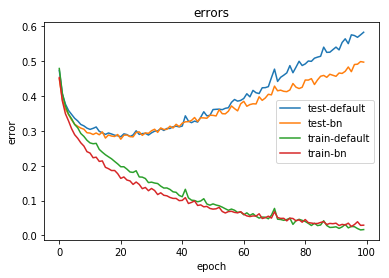

In [74]:
plot_graphs(log, 'loss')

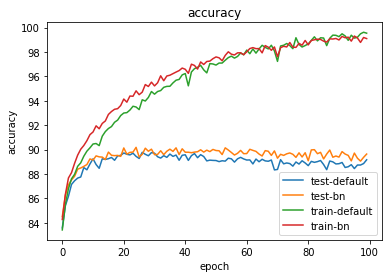

In [75]:
plot_graphs(log, 'accuracy')